In [99]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier

In [100]:
def preprocess_data(df):
  df['Name Title'] = df['Name'].str.extract(r'\b(Mr\.?|Mrs\.?|Miss\.?|Master\.?)\b')
  df['Name Title'] = df['Name Title'].fillna(value = 'Other')
  group_means = df.groupby('Name Title')['Age'].transform('mean')
  df['Age Filled'] = df['Age'].fillna(group_means)
  mean = df[df['Age Filled'].notnull()]['Age Filled'].mean()
  df['Age Filled'] = df['Age Filled'].fillna(value = mean)
  mean = df[df['Fare'].notnull()]['Fare'].mean()
  df['Fare'] = df['Fare'].fillna(value = mean)

  one_hot_Embarked = pd.get_dummies(df['Embarked'], prefix = 'Embarked').astype(int)
  df = pd.concat([df, one_hot_Embarked], axis = 1)
  one_hot_Sex = pd.get_dummies(df['Sex']).astype(int)
  df = pd.concat([df, one_hot_Sex], axis = 1)
  one_hot_Name_Title = pd.get_dummies(df['Name Title']).astype(int)
  df = pd.concat([df, one_hot_Name_Title], axis = 1)
  df['Cabin_Deck'] = df['Cabin'].str[0].fillna('Unknown')

  features = [
    'Pclass', 'Age Filled', 'SibSp', 'Parch', 'Fare',
    'Embarked_C', 'Embarked_Q', 'Embarked_S',
    'female', 'male',
    'Master', 'Miss', 'Mr', 'Mrs', 'Other',
    'Cabin_Deck'
    ]
  X = df[features]
  # y = df['Survived']

  one_hot_Cabin_Deck = pd.get_dummies(df['Cabin_Deck']).astype(int)
  X = pd.concat([X, one_hot_Cabin_Deck], axis = 1)
  X = X.drop(columns = 'Cabin_Deck')

  scaler = StandardScaler()
  X[['Age Filled', 'Fare']] = scaler.fit_transform(X[['Age Filled', 'Fare']])

  return X

In [101]:
df = pd.read_csv(r"/train.csv")
# df.head(20)

## 將Age分成(Mr/Mrs/Miss/Master), 使用各種分類的平均年齡處理Age缺失值

In [102]:
df['Name Title'] = df['Name'].str.extract(r'\b(Mr\.?|Mrs\.?|Miss\.?|Master\.?)\b')
df['Name Title'] = df['Name Title'].fillna(value = 'Other')
group_means = df.groupby('Name Title')['Age'].transform('mean')
df['Age Filled'] = df['Age'].fillna(group_means)
mean = df[df['Age Filled'].notnull()]['Age Filled'].mean()
df['Age Filled'] = df['Age Filled'].fillna(value = mean)
df.isnull().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


## 使用one hot處理數據

In [103]:
one_hot_Embarked = pd.get_dummies(df['Embarked'], prefix = 'Embarked').astype(int)
df = pd.concat([df, one_hot_Embarked], axis = 1)
# df

In [104]:
one_hot_Sex = pd.get_dummies(df['Sex']).astype(int)
df = pd.concat([df, one_hot_Sex], axis = 1)
# df

In [105]:
one_hot_Name_Title = pd.get_dummies(df['Name Title']).astype(int)
df = pd.concat([df, one_hot_Name_Title], axis = 1)
# df

In [106]:
df['Cabin_Deck'] = df['Cabin'].str[0].fillna('Unknown')
# df

In [107]:
# df = df.drop(columns = ['Sex', 'Age', 'Embarked', 'Name Title', 'PassengerId', 'Cabin'])
# df

In [108]:
# df.isnull().sum()

In [109]:
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Embarked_Q,Embarked_S,female,male,Master,Miss,Mr,Mrs,Other,Cabin_Deck
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,0,1,0,1,0,0,1,0,0,Unknown
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,0,0,1,0,0,0,0,1,0,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,0,1,1,0,0,1,0,0,0,Unknown
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,0,1,1,0,0,0,0,1,0,C
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,0,1,0,1,0,0,1,0,0,Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,...,0,1,0,1,0,0,0,0,1,Unknown
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,...,0,1,1,0,0,1,0,0,0,B
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,...,0,1,1,0,0,1,0,0,0,Unknown
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,...,0,0,0,1,0,0,1,0,0,C


##分出features and label

In [110]:
features = [
    'Pclass', 'Age Filled', 'SibSp', 'Parch', 'Fare',
    'Embarked_C', 'Embarked_Q', 'Embarked_S',
    'female', 'male',
    'Master', 'Miss', 'Mr', 'Mrs', 'Other',
    'Cabin_Deck'
    ]
X = df[features]
y = df['Survived']

In [111]:
one_hot_Cabin_Deck = pd.get_dummies(df['Cabin_Deck']).astype(int)
X = pd.concat([X, one_hot_Cabin_Deck], axis = 1)
X = X.drop(columns = 'Cabin_Deck')
X

,Pclass,Age Filled,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,female,male,...,Other,A,B,C,D,E,F,G,T,Unknown
0,3,22.000000,1,0,7.2500,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,1
1,1,38.000000,1,0,71.2833,1,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
2,3,26.000000,0,0,7.9250,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1
3,1,35.000000,1,0,53.1000,0,0,1,1,0,...,0,0,0,1,0,0,0,0,0,0
4,3,35.000000,0,0,8.0500,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,2,27.000000,0,0,13.0000,0,0,1,0,1,...,1,0,0,0,0,0,0,0,0,1
887,1,19.000000,0,0,30.0000,0,0,1,1,0,...,0,0,1,0,0,0,0,0,0,0
888,3,21.773973,1,2,23.4500,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1
889,1,26.000000,0,0,30.0000,1,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0


## 標準化

In [112]:
scaler = StandardScaler()
X[['Age Filled', 'Fare']] = scaler.fit_transform(X[['Age Filled', 'Fare']])
X.isnull().sum(axis = 0)

,0
Pclass,0
Age Filled,0
SibSp,0
Parch,0
Fare,0
Embarked_C,0
Embarked_Q,0
Embarked_S,0
female,0
male,0


## training set, test set, val test

In [113]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size = 0.25, random_state=42)
columns_used = X_train.columns.tolist()

In [114]:
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Embarked_Q,Embarked_S,female,male,Master,Miss,Mr,Mrs,Other,Cabin_Deck
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,0,1,0,1,0,0,1,0,0,Unknown
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,0,0,1,0,0,0,0,1,0,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,0,1,1,0,0,1,0,0,0,Unknown
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,0,1,1,0,0,0,0,1,0,C
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,0,1,0,1,0,0,1,0,0,Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,...,0,1,0,1,0,0,0,0,1,Unknown
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,...,0,1,1,0,0,1,0,0,0,B
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,...,0,1,1,0,0,1,0,0,0,Unknown
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,...,0,0,0,1,0,0,1,0,0,C


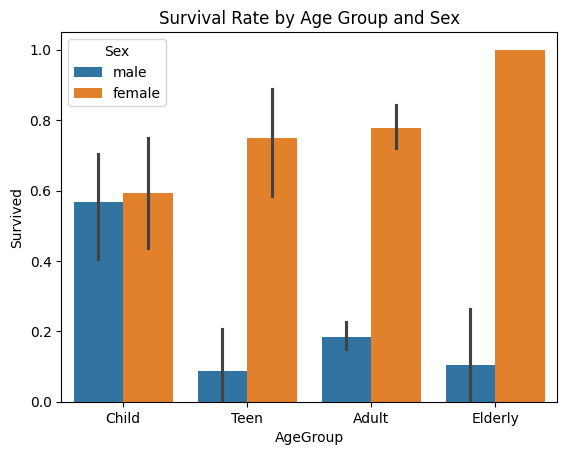

In [115]:
df['AgeGroup'] = pd.cut(df['Age'], bins=[0, 12, 18, 60, 100], labels=['Child', 'Teen', 'Adult', 'Elderly'])
sns.barplot(data=df, x='AgeGroup', y='Survived', hue='Sex')
plt.title('Survival Rate by Age Group and Sex')
plt.show()

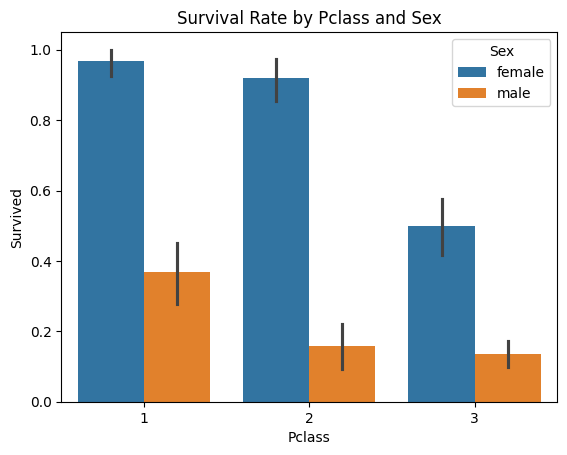

In [116]:
sns.barplot(data = df, x = 'Pclass', y = 'Survived', hue = 'Sex')
plt.title('Survival Rate by Pclass and Sex')
plt.show()

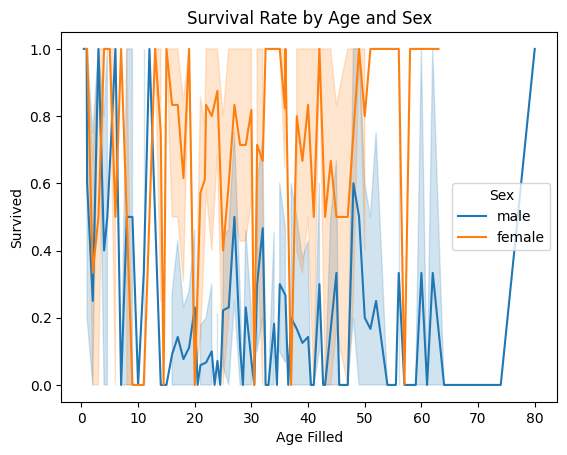

In [117]:
sns.lineplot(data = df, x = 'Age Filled', y = 'Survived', hue = 'Sex')
plt.title('Survival Rate by Age and Sex')
plt.show()

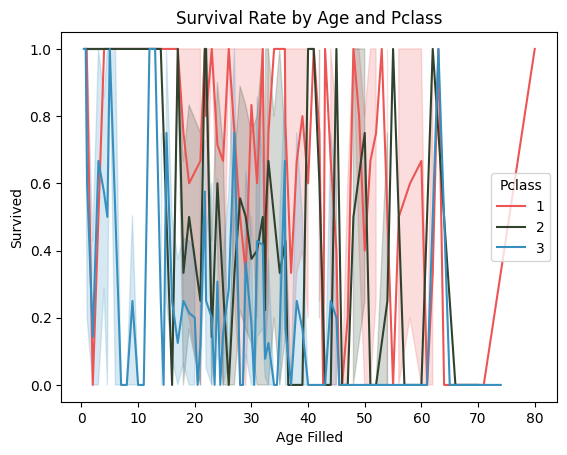

In [118]:
sns.lineplot(data = df, x = 'Age Filled', y = 'Survived', hue = 'Pclass', palette=['#ed5555', '#30422e', '#368fbf'],)
plt.title('Survival Rate by Age and Pclass')
plt.show()

## 架設logistic regression模型 選擇最好的regularization C value

In [119]:
C_values = np.linspace(0.001, 100, 100)
val_accuracy = []
for i in C_values:
  model = LogisticRegression(penalty = 'l2', C = i, solver = 'liblinear')
  model.fit(X_train, y_train)
  y_val_pred = model.predict(X_val)
  accuracy = accuracy_score(y_val, y_val_pred)
  val_accuracy.append(accuracy)
  # print(f'C value:{i:8.3f}, accuracy:{accuracy:.3f}')

best_C = C_values[np.argmax(val_accuracy)]
best_accuracy = max(val_accuracy)
print(f'best C value:{best_C:.3f}, best accuracy:{best_accuracy:.3f}')

best C value:1.011, best accuracy:0.820


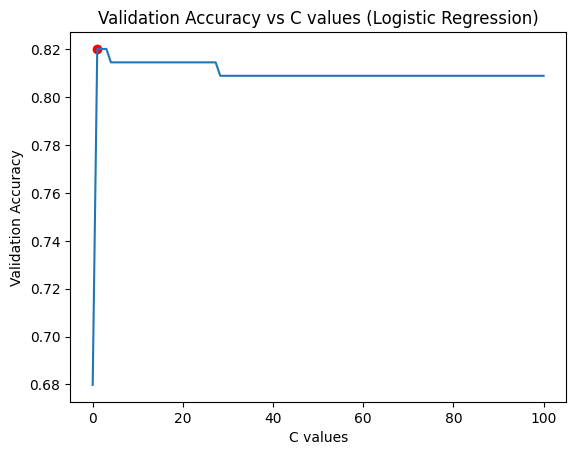

In [120]:
plt.plot(C_values, val_accuracy)
plt.scatter(best_C,best_accuracy, color = 'red')
plt.xlabel('C values')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs C values (Logistic Regression)')
plt.show()

In [121]:
X_trainval = np.concatenate((X_train, X_val), axis=0)
y_trainval = np.concatenate((y_train, y_val), axis=0)
model = LogisticRegression(penalty = 'l2', C = best_C, solver = 'liblinear')
train_sizes, train_scores, val_scores = learning_curve(
    model, X_trainval, y_trainval,
    cv = 5,
    train_sizes = np.linspace(0.1, 1.0, 500),
    random_state = 42
)

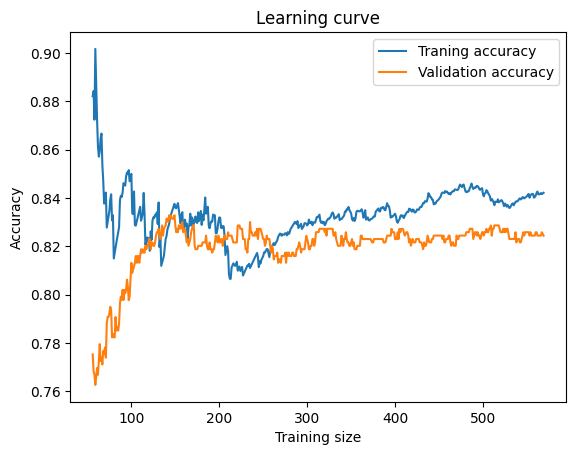

In [122]:
train_mean = train_scores.mean(axis = 1)
val_mean = val_scores.mean(axis = 1)
plt.plot(train_sizes, train_mean, label = 'Traning accuracy')
plt.plot(train_sizes, val_mean, label = 'Validation accuracy')
plt.xlabel('Training size')
plt.ylabel('Accuracy')
plt.title('Learning curve')
plt.legend()
plt.show()

## 建立XGBoost模型

In [123]:
lambdas = np.linspace(0.001, 100, 100)
val_accuracy = []
val_logloss = []
X_train = np.array(X_train)  # 比 np.array() 更安全，不會複製已為array的數據
X_val = np.array(X_val)
y_train = np.array(y_train).ravel()  # 確保y是1D array
y_val = np.array(y_val).ravel()
for i in lambdas:
  xgb_model = XGBClassifier(
      n_estimators = 500,
      max_depth=5,
      learning_rate = 0.1,
      reg_lambda = i,
      early_stopping_rounds = 10,
      random_state=42
  )
  xgb_model.fit(
      X_train, y_train,
      eval_set = [(X_val, y_val)],
      verbose=False
  )

  best_round = xgb_model.best_iteration
  y_val_pred = xgb_model.predict(X_val, iteration_range=(0, best_round + 1))
  accuracy = accuracy_score(y_val, y_val_pred)
  val_accuracy.append(accuracy)
  # print(f'lambda:{i:7.3f}, accuracy:{accuracy:.3f}')

  eval_result = xgb_model.evals_result()
  logloss = eval_result['validation_0']['logloss'][best_round]
  val_logloss.append(logloss)

best_lambda = lambdas[np.argmax(val_accuracy)]
best_accuracy = max(val_accuracy)
print(f'best lambda:{best_lambda:7.3f}, best accuracy:{best_accuracy:.3f}')

best lambda: 57.576, best accuracy:0.871


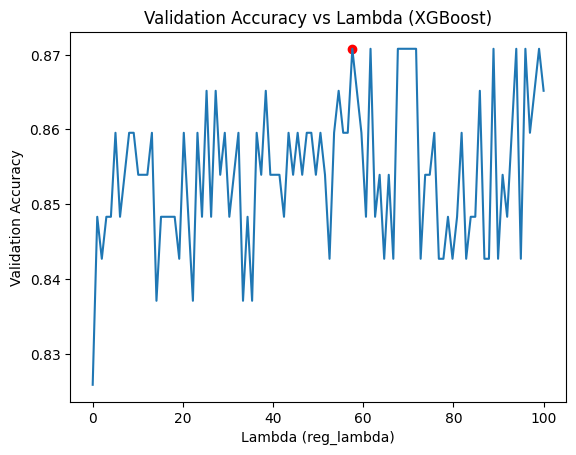

In [124]:
plt.plot(lambdas, val_accuracy)
plt.scatter(best_lambda,best_accuracy, color = 'red')
plt.xlabel('Lambda (reg_lambda)')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs Lambda (XGBoost)')
plt.show()

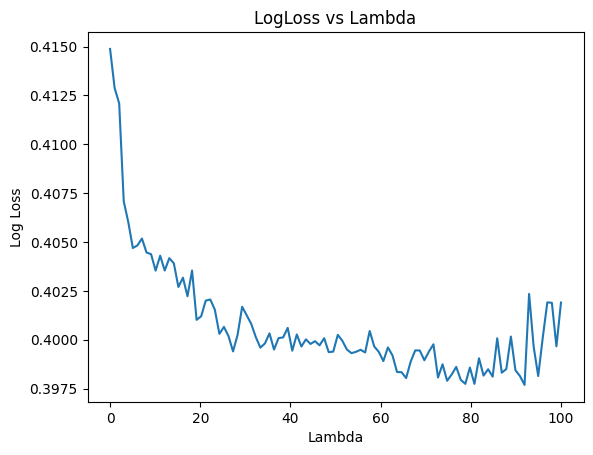

In [125]:
plt.plot(lambdas, val_logloss, label='Validation LogLoss')
plt.xlabel('Lambda')
plt.ylabel('Log Loss')
plt.title('LogLoss vs Lambda')
plt.show()

In [126]:
X_trainval = np.concatenate((X_train, X_val), axis=0)
y_trainval = np.concatenate((y_train, y_val), axis=0)
xgb_model = XGBClassifier(
      n_estimators = 500,
      max_depth=5,
      learning_rate = 0.1,
      reg_lambda = best_lambda,
      random_state=42
  )
train_sizes, train_scores, val_scores = learning_curve(
    estimator = xgb_model,
    X = X_trainval, y = y_trainval,
    cv=5,
    train_sizes=np.linspace(0.1, 1.0, 100),
    scoring='accuracy',
    n_jobs=-1
)

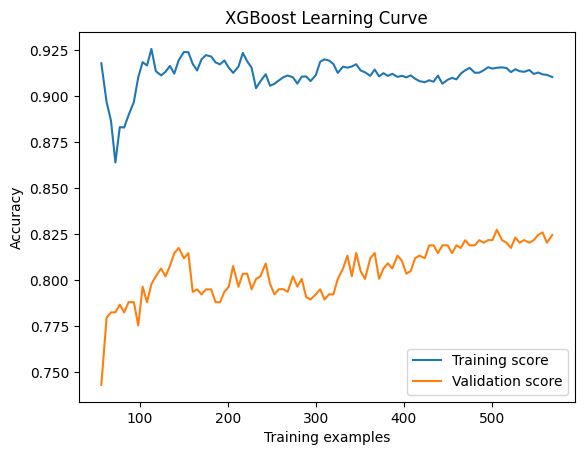

In [127]:
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training score')
plt.plot(train_sizes, np.mean(val_scores, axis=1), label='Validation score')
plt.title("XGBoost Learning Curve")
plt.xlabel("Training examples")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## 收尾

In [128]:
final_logistic_model = LogisticRegression(
    penalty = 'l2',
    C = best_C,
    solver = 'liblinear'
)
final_logistic_model.fit(X_trainval, y_trainval)
y_test_pred = final_logistic_model.predict(X_test)
accuracy = accuracy_score(y_test, y_test_pred)
print(f'Logistic test accuracy:{accuracy:.3f}')

Logistic test accuracy:0.816


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [129]:
best_n_estimators = best_round + 1
final_xgb_model = XGBClassifier(
    n_estimators = best_n_estimators,
    max_depth = 5,
    learning_rate = 0.1,
    reg_lambda = best_lambda,
    random_state = 42
)
final_xgb_model.fit(X_trainval, y_trainval)
y_test_pred = final_xgb_model.predict(np.array(X_test))
accuracy = accuracy_score(y_test, y_test_pred)
print(f'accuracy:{accuracy:.3f}')

accuracy:0.838


## 開始預測

In [130]:
df_test = pd.read_csv('/test.csv')
X = preprocess_data(df_test)

X = X.reindex(columns=columns_used, fill_value=0)
print(X.shape)

(418, 24)


## 試試用logistic regression model

In [131]:
y_pred_logistic = final_logistic_model.predict(X)
y_pred_logistic

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [132]:
result = pd.DataFrame({
    'PassengerId': df_test['PassengerId'],
    'Survived': y_pred_logistic  # 放一維陣列
})
result.to_csv('logistic_regression_model_result.csv', index=False)

## 試試用XGBoost model

In [133]:
df_test = pd.read_csv('/test.csv')
X = preprocess_data(df_test)
X = X.reindex(columns=columns_used, fill_value=0)
print(X.shape)

(418, 24)


In [134]:
y_pred_XGBoost = final_xgb_model.predict(np.array(X))
y_pred_XGBoost

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

## 保存結果

In [135]:
result = pd.DataFrame({
    'PassengerId': df_test['PassengerId'],
    'Survived': y_pred_XGBoost  # 放一維陣列
})
result.to_csv('XGBoost_model_ressult.csv', index=False)